# Analysis of Vodafone users' fluxes

The study of the flux of people inside urban areas is of paramount importance to achieve an optimal understanding of emerging critical issues in the local mobility, and to explore areas of potential improvements in the infrastructures and local transports.

The mobility of users within and toward Padova has been monitored using the data provided by the Vodafone mobile carrier, which provides the information based on the users' connections to the network cells.
The data provided by the carrier encompasses the monitoring of the users connected to the Vodafone network in Padova in a four-month period from February to May of 2018.

To provide statistical insights on the number and the flow of users, the data is aggregated based on the origin and movements of the users by averaging the number of connections during the time of the monitoring.

To further avoid privacy violation issues, all observations with less than 30 units (e.g. day-areas for which $<$30 users have contributed) have been discarded and/or merged into dedicated categories (indicated with "altro", or "other").


## Datasets 

The data is provided in `.csv` files.

* __day_od.csv__: table of the origins and destinations of the users averaged by the day of the week. The data is provided with details of the month, type of user (resident in Padova/Italian visitor/foreign visitor), country of provenance, together with the province and comune of the user (if available).
* __distinct_users_day.csv__: table of the number of distinct users by origin. The data is provided with details of the month, type of user (resident in Padova/Italian visitor/foreign visitor), country of provenance, together with the province and comune of the user (if available).

The information is stored in the fields according to the following scheme: 

- __MONTH__: month analyzed
- __DOW__: day analyzed
- __ORIGIN__: users' origin area (do not consider this field)
- __DESTINATION__: users' destination area (do not consider this field)
- __CUST_CLASS__: user type (resident / Italian visitor / foreigner visitor)
- __COD_COUNTRY__: users' country code (e.g. 222=Italy)
- __COD_PRO__: users' province code (e.g. 12=Varese) 
- __PRO_COM__: users' comune code (e.g. 12026=Busto Arsizio)
- __FLOW__: number of movements for given date-time (with a minimum of 30 users)
- __VISITORS__: overall number of users 

Together with the data files, three lookup-tables are provided to allow matching the Italian institute of STATistics (ISTAT) country, province and comune codes to the actual names.

* __codici_istat_comune.csv__: lookup file containing the mapping between _comune_ ISTAT code-names
* __codici_istat_provincia.csv__: lookup file containing the mapping between _province_ ISTAT code-names
* __codici_nazioni.csv__: lookup file containing mapping the _country_ code to its name

Additional information, useful for the study of the flow of users, as the number of inhabitants of each province and the distance between Padova and all other Italian provinces can be extracted based on the data collected by the ISTAT:

   - English: https://www.istat.it/en/analysis-and-products/databases, Italian: https://www.istat.it/it/dati-analisi-e-prodotti/banche-dati
   
   - English/Italian: https://www.istat.it/en/archive/157423, Italian: https://www.istat.it/it/archivio/157423
   
   - `.zip` package containing the distances between comuni in Veneto region: http://www.istat.it/storage/cartografia/matrici_distanze/Veneto.zip

If deemed useful, the open repository [https://github.com/openpolis/geojson-italy](https://github.com/openpolis/geojson-italy) contains a `.json` file with the geographical coordinates of the provences and comuni of Italy.


## Assignments

1. Data preparation: the csv files are originated from different sources, hence resulting in differences in the encoding and end-of-lines that have to be taken into account in the data preparation phase. Make sure each .csv file is properly interpreted.

   1.1 Ranking of visitors from foreign countries: based on the number of total visitors per each country, create a ranked plot of the first 20 countries with the most visitors
   
   1.2 Ranking of Italian visitors by province, weighted by the number of inhabitants: based on the number of total visitors per Italian province, create a ranked plot of the first 20 provinces with the most visitors taking into account the number of inhabitants.


2. Study of the visitors' fluxes: you are asked to provide indications on how to invest resources to improve the mobility towards Padova. Consider the three main directions of visitors and commuters getting to Padova through the main highways (from south, A13 towards Bologna-Roma; from west, A4 towards Milano-Torino; from north-east, A4 towards Venice-Trieste). Evaluate which of the three directions has to be prioritized.

   2.1 Consider a simplified case involving only the mid-range mobility, based on the number of visitors/commuters from the nearby regions only
   
   2.2 Consider the provinces located on the three directions that are mostly contributing to the flow of weekend visitors and working daily commuters by performing a more detailed study of the fluxes based on the day of the week. Use the data available to provide what you believe is the best possible answer.


3. Plot the distribution of the number of visitors by the distance of the province of origin. Determine which kind of function should be used to describe the distribution.

   3.1 Assuming an analytic form can be used to describe the trend, create a regression or a fit to estimate the expected number of visitors by the distance of the province of origin and the corresponding uncertainties. Illustrate the difference between the resulting regression with respect to the numbers provided by the Vodafone monitoring, and highlight the five most striking discrepancies from the expectations.

In [128]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import geopandas as gpd
from math import radians, cos, sin, asin, sqrt

In [2]:
# 1.1
df_nations = pd.read_csv('codici_nazioni.csv',sep=',',encoding="utf-16") # mbcs indicates the csv file was UCS-2 BE BOM encoded, not UTF-8.
df2 = pd.read_csv('distinct_users_day.csv',sep=',',encoding='mbcs') # mbcs indicates the csv file was ANSI encoded, not UTF-8.
df3 = df2.merge(df_nations) # cod_countries are matched with nations lookup table

In [3]:
df3 = df3[df3['CUST_CLASS'].str.match('foreigner')]
df3

,DOW,CUST_CLASS,COD_COUNTRY,COD_PRO,PRO_COM,VISITORS,COUNTRY_NAME_IT
12319,Giovedì,foreigner,226.0,NaN,NaN,8944,Romania
12320,Venerdì,foreigner,226.0,NaN,NaN,9840,Romania
12321,Lunedì,foreigner,226.0,NaN,NaN,8388,Romania
12322,Domenica,foreigner,226.0,NaN,NaN,7028,Romania
12323,Sabato,foreigner,226.0,NaN,NaN,7992,Romania
...,...,...,...,...,...,...,...
12830,Venerdì,foreigner,220.0,NaN,NaN,1360,Serbia
12831,Sabato,foreigner,220.0,NaN,NaN,1980,Serbia
12832,Domenica,foreigner,413.0,NaN,NaN,72,Sri Lanka
12833,Lunedì,foreigner,413.0,NaN,NaN,60,Sri Lanka


In [4]:
df_rank = df3.groupby(['COD_COUNTRY','COUNTRY_NAME_IT']).sum().reset_index()
df_rank

,COD_COUNTRY,COUNTRY_NAME_IT,COD_PRO,PRO_COM,VISITORS
0,202.0,Grecia,0.0,0.0,7960
1,204.0,Paesi Bassi,0.0,0.0,70432
2,206.0,Belgio,0.0,0.0,25380
3,208.0,Francia,0.0,0.0,129672
4,214.0,Spagna,0.0,0.0,71872
...,...,...,...,...,...
73,722.0,Argentina,0.0,0.0,5796
74,724.0,Brasile,0.0,0.0,8544
75,730.0,Cile,0.0,0.0,1640
76,732.0,Colombia,0.0,0.0,496


Text(0.5, 0, 'Countries')

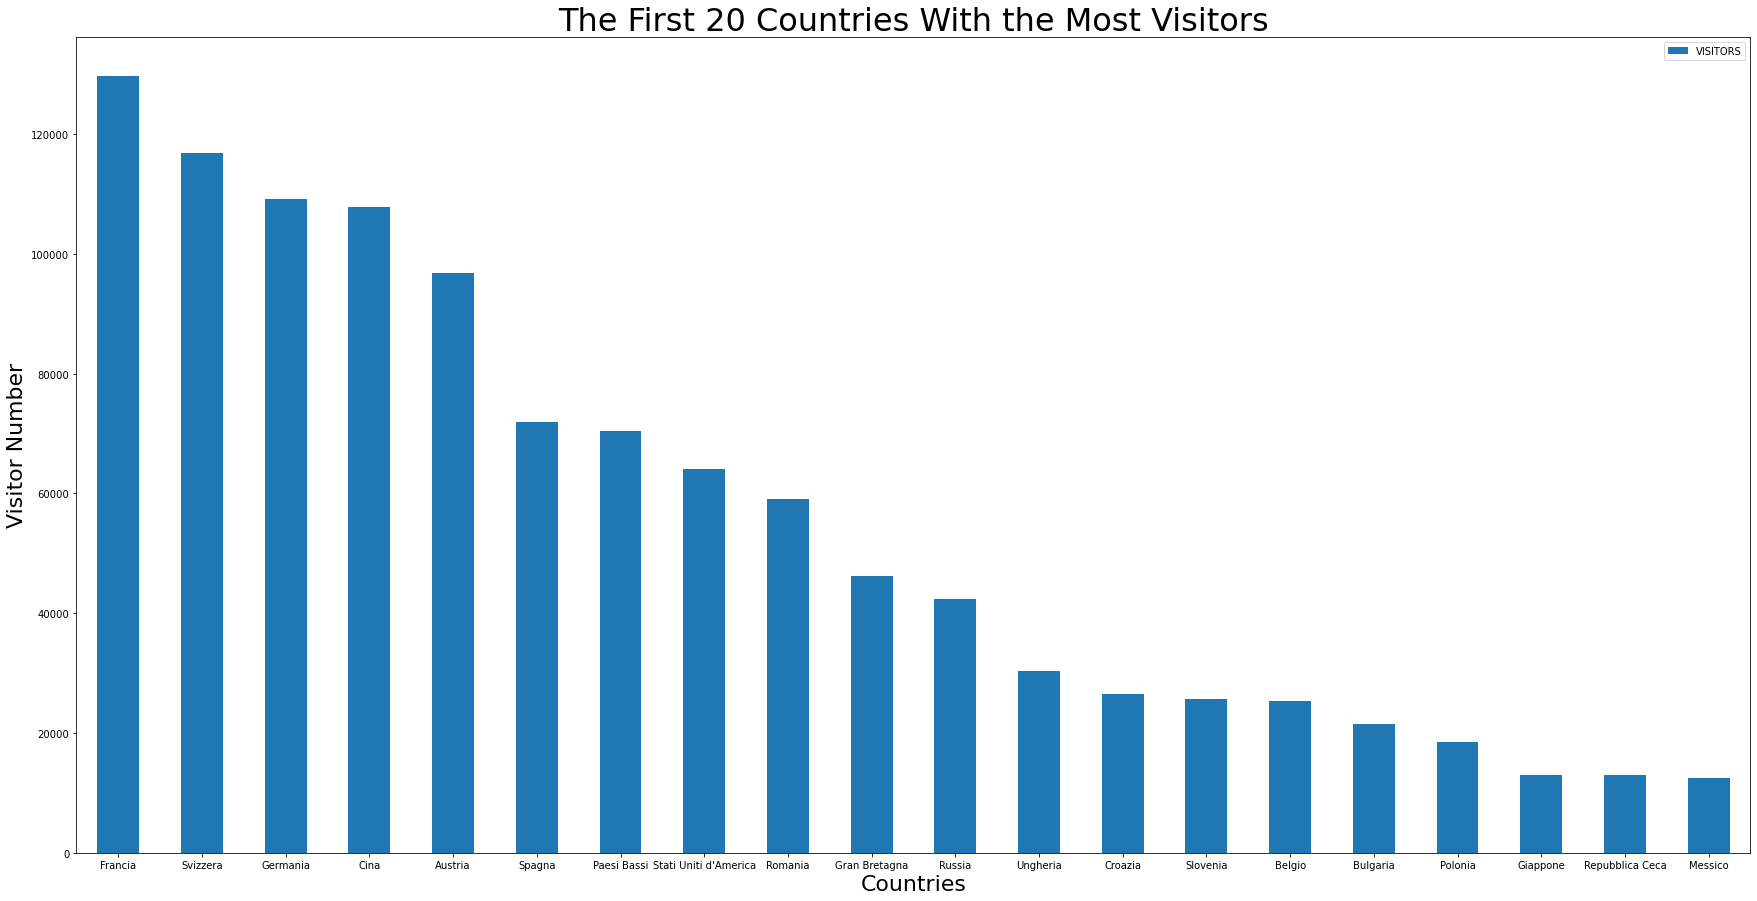

In [5]:
#df_rank.to_csv('first_assignment.csv', sep='\t', encoding='utf-8') # saves the df into a UTF-8 coded csv file
df_first20 = df_rank.sort_values('VISITORS',ascending = False).head(20) # sort the df and gets the first 20 rows

#PLOTTING PART
ax = df_first20.plot.bar(x='COUNTRY_NAME_IT', y='VISITORS', rot=0,figsize=(30, 15))
ax.set_title('The First 20 Countries With the Most Visitors', fontdict={'size':32})
ax.set_ylabel(ylabel='Visitor Number', fontdict={'size':22})
ax.set_xlabel(xlabel='Countries', fontdict={'size':22})

In [6]:
#1.2  wieghted by the inhabitants derken???
df_province = pd.read_csv('codici_istat_provincia.csv',sep=',',encoding="mbcs") # mbcs indicates the csv file was ANSI encoded, not UTF-8.
df2 = pd.read_csv('distinct_users_day.csv',sep=',',encoding='mbcs') 
df3 = df2.merge(df_province) # cod_pro are matched with nations lookup table
df3

,DOW,CUST_CLASS,COD_COUNTRY,COD_PRO,PRO_COM,VISITORS,COD_REG,PROVINCIA,PROV_SIGLA
0,Mercoledì,visitor,222.0,35.0,35033.0,968,8,Reggio nell'Emilia,RE
1,Sabato,visitor,222.0,35.0,35040.0,112,8,Reggio nell'Emilia,RE
2,Lunedì,visitor,222.0,35.0,35027.0,76,8,Reggio nell'Emilia,RE
3,Mercoledì,visitor,222.0,35.0,35004.0,36,8,Reggio nell'Emilia,RE
4,Lunedì,visitor,222.0,35.0,35036.0,156,8,Reggio nell'Emilia,RE
...,...,...,...,...,...,...,...,...,...
12264,Mercoledì,visitor,222.0,57.0,57059.0,64,12,Rieti,RI
12265,Sabato,visitor,222.0,57.0,57059.0,68,12,Rieti,RI
12266,Giovedì,visitor,222.0,57.0,57059.0,68,12,Rieti,RI
12267,Martedì,visitor,222.0,57.0,57059.0,68,12,Rieti,RI


In [7]:
df_inhabitant = pd.read_csv('population_2019.csv',sep=',',encoding="mbcs")
df_inhabitant = df_inhabitant[['Territory', 'Value']]
df_inhabitant = df_inhabitant.rename(columns={"Value": "Inhabitants"})
df_inhabitant

,Territory,Inhabitants
0,Italy,59816673
1,Nord-ovest,15998031
2,Piemonte,4328565
3,Torino,2238663
4,Vercelli,170493
...,...,...
130,Agrigento,428003
131,Siracusa,391400
132,Oristano,156623
133,Monza e della Brianza,867385


In [8]:
#df4 = df3.merge(df_inhabitant) # cod_pro are matched with nations lookup table
df4 = pd.merge(left=df3, right=df_inhabitant, left_on='PROVINCIA', right_on='Territory')
df4

,DOW,CUST_CLASS,COD_COUNTRY,COD_PRO,PRO_COM,VISITORS,COD_REG,PROVINCIA,PROV_SIGLA,Territory,Inhabitants
0,Mercoledì,visitor,222.0,35.0,35033.0,968,8,Reggio nell'Emilia,RE,Reggio nell'Emilia,529932
1,Sabato,visitor,222.0,35.0,35040.0,112,8,Reggio nell'Emilia,RE,Reggio nell'Emilia,529932
2,Lunedì,visitor,222.0,35.0,35027.0,76,8,Reggio nell'Emilia,RE,Reggio nell'Emilia,529932
3,Mercoledì,visitor,222.0,35.0,35004.0,36,8,Reggio nell'Emilia,RE,Reggio nell'Emilia,529932
4,Lunedì,visitor,222.0,35.0,35036.0,156,8,Reggio nell'Emilia,RE,Reggio nell'Emilia,529932
...,...,...,...,...,...,...,...,...,...,...,...
11935,Mercoledì,visitor,222.0,57.0,57059.0,64,12,Rieti,RI,Rieti,153534
11936,Sabato,visitor,222.0,57.0,57059.0,68,12,Rieti,RI,Rieti,153534
11937,Giovedì,visitor,222.0,57.0,57059.0,68,12,Rieti,RI,Rieti,153534
11938,Martedì,visitor,222.0,57.0,57059.0,68,12,Rieti,RI,Rieti,153534


In [9]:
df4 = df4[df4['CUST_CLASS'].str.match('visitor')]
df4

,DOW,CUST_CLASS,COD_COUNTRY,COD_PRO,PRO_COM,VISITORS,COD_REG,PROVINCIA,PROV_SIGLA,Territory,Inhabitants
0,Mercoledì,visitor,222.0,35.0,35033.0,968,8,Reggio nell'Emilia,RE,Reggio nell'Emilia,529932
1,Sabato,visitor,222.0,35.0,35040.0,112,8,Reggio nell'Emilia,RE,Reggio nell'Emilia,529932
2,Lunedì,visitor,222.0,35.0,35027.0,76,8,Reggio nell'Emilia,RE,Reggio nell'Emilia,529932
3,Mercoledì,visitor,222.0,35.0,35004.0,36,8,Reggio nell'Emilia,RE,Reggio nell'Emilia,529932
4,Lunedì,visitor,222.0,35.0,35036.0,156,8,Reggio nell'Emilia,RE,Reggio nell'Emilia,529932
...,...,...,...,...,...,...,...,...,...,...,...
11935,Mercoledì,visitor,222.0,57.0,57059.0,64,12,Rieti,RI,Rieti,153534
11936,Sabato,visitor,222.0,57.0,57059.0,68,12,Rieti,RI,Rieti,153534
11937,Giovedì,visitor,222.0,57.0,57059.0,68,12,Rieti,RI,Rieti,153534
11938,Martedì,visitor,222.0,57.0,57059.0,68,12,Rieti,RI,Rieti,153534


In [10]:
df_rank = df4.groupby(['COD_PRO','PROVINCIA','Inhabitants']).sum().reset_index()
df_rank['Weighted Value'] = df_rank.apply(lambda row: (row['VISITORS']*row['Inhabitants']), axis=1)
#df_rank['Weighted Value'] = df_rank[df_rank['VISITORS']* df_rank['Inhabitants']]
df_rank = df_rank.drop('PRO_COM', 1)
df_rank = df_rank.drop('COD_REG', 1)
df_rank = df_rank.drop('COD_COUNTRY', 1)
df_rank

,COD_PRO,PROVINCIA,Inhabitants,VISITORS,Weighted Value
0,1.0,Torino,2238663,39068,87460086084
1,2.0,Vercelli,170493,1940,330756420
2,3.0,Novara,365773,9164,3351943772
3,4.0,Cuneo,587213,3372,1980082236
4,5.0,Asti,213504,1440,307445760
...,...,...,...,...,...
97,102.0,Vibo Valentia,156378,428,66929784
98,103.0,Verbano-Cusio-Ossola,157278,2000,314556000
99,108.0,Monza e della Brianza,867385,30648,26583615480
100,109.0,Fermo,172681,2676,462094356


Text(0.5, 0, 'Provincies')

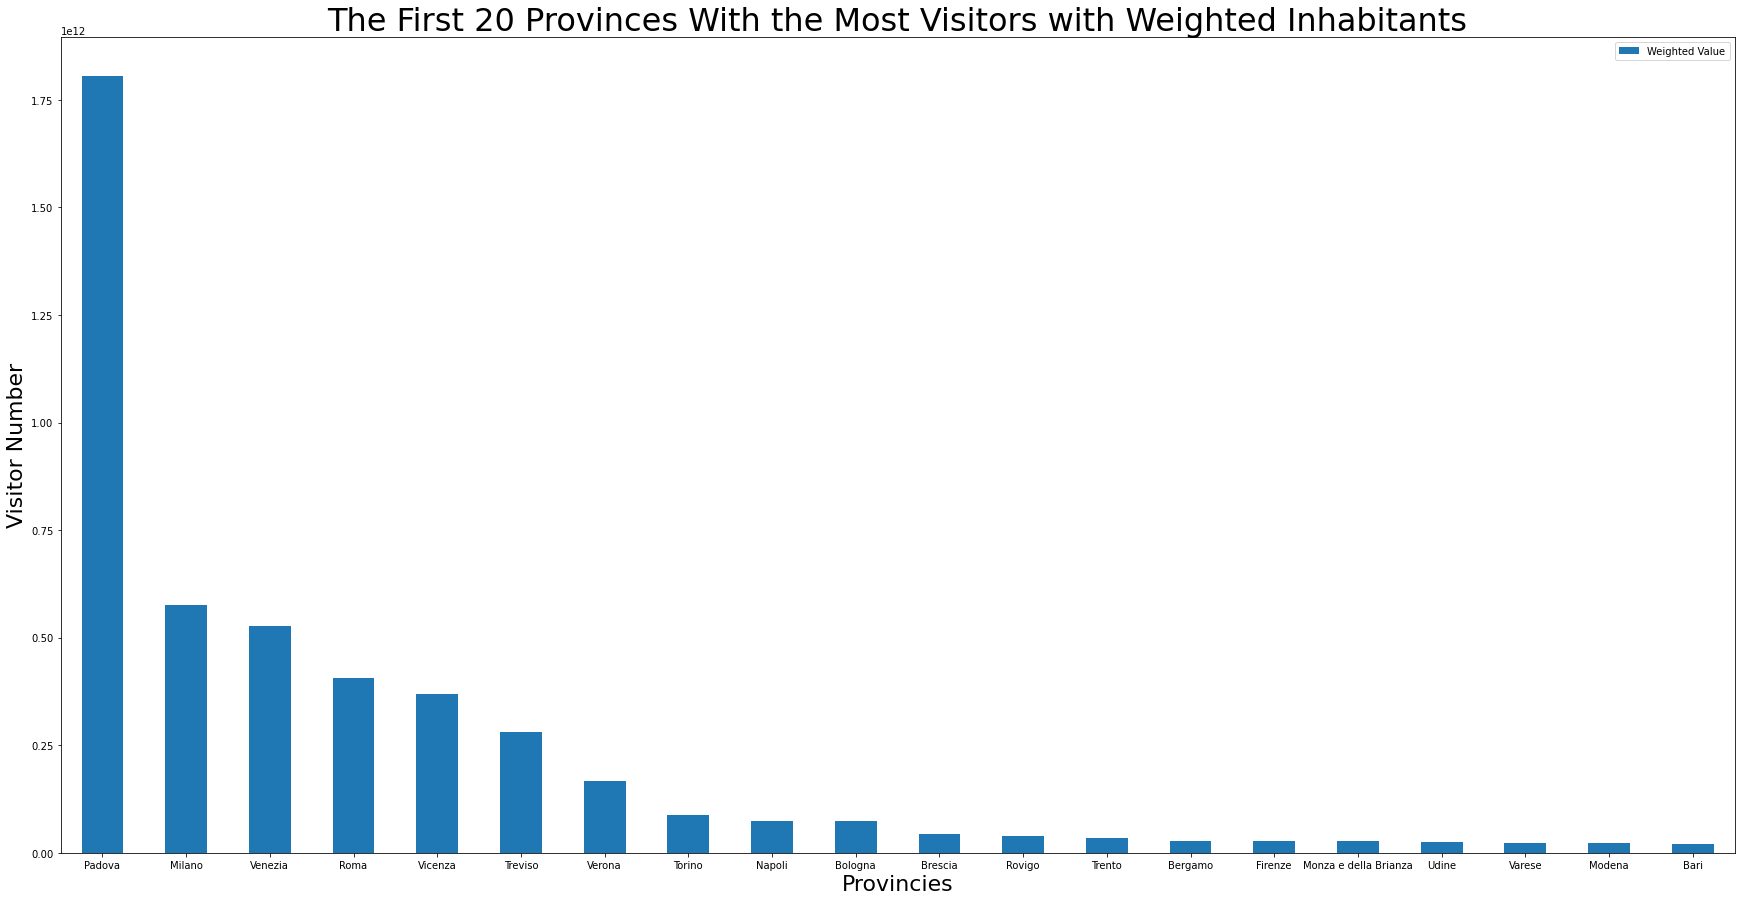

In [11]:
#df_rank.to_csv('first_assignment.csv', sep='\t', encoding='utf-8') # saves the df into a UTF-8 coded csv file
df_first20 = df_rank.sort_values('Weighted Value',ascending = False).head(20) # sort the df and gets the first 20 rows

#PLOTTING PART
ax = df_first20.plot.bar(x='PROVINCIA', y='Weighted Value', rot=0,figsize=(30, 15))
ax.set_title('The First 20 Provinces With the Most Visitors with Weighted Inhabitants', fontdict={'size':32})
ax.set_ylabel(ylabel='Visitor Number', fontdict={'size':22})
ax.set_xlabel(xlabel='Provincies', fontdict={'size':22})

In [245]:
#Q3

df_province = pd.read_csv('codici_istat_provincia.csv',sep=',',encoding="mbcs") # mbcs indicates the csv file was ANSI encoded, not UTF-8.
df2 = pd.read_csv('distinct_users_day.csv',sep=',',encoding='mbcs') 
df3 = df2.merge(df_province) # cod_pro are matched with nations lookup table
df3[df3["CUST_CLASS"].str.contains("visitor")==True] # residents are removed

,DOW,CUST_CLASS,COD_COUNTRY,COD_PRO,PRO_COM,VISITORS,COD_REG,PROVINCIA,PROV_SIGLA
0,Mercoledì,visitor,222.0,35.0,35033.0,968,8,Reggio nell'Emilia,RE
1,Sabato,visitor,222.0,35.0,35040.0,112,8,Reggio nell'Emilia,RE
2,Lunedì,visitor,222.0,35.0,35027.0,76,8,Reggio nell'Emilia,RE
3,Mercoledì,visitor,222.0,35.0,35004.0,36,8,Reggio nell'Emilia,RE
4,Lunedì,visitor,222.0,35.0,35036.0,156,8,Reggio nell'Emilia,RE
...,...,...,...,...,...,...,...,...,...
12264,Mercoledì,visitor,222.0,57.0,57059.0,64,12,Rieti,RI
12265,Sabato,visitor,222.0,57.0,57059.0,68,12,Rieti,RI
12266,Giovedì,visitor,222.0,57.0,57059.0,68,12,Rieti,RI
12267,Martedì,visitor,222.0,57.0,57059.0,68,12,Rieti,RI


In [246]:
df_rank = df3.groupby(['COD_PRO','PROVINCIA']).sum().reset_index()
df_rank = df_rank.sort_values('VISITORS',ascending = False)
df_rank = df_rank.drop('COD_PRO',1)
df_rank = df_rank.drop('COD_COUNTRY',1)
df_rank = df_rank.drop('PRO_COM',1)
df_rank = df_rank.drop('COD_REG',1)
df_rank = df_rank.reset_index()
df_rank

C:\Users\Mustafa\AppData\Local\Temp/ipykernel_6548/1087661631.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_rank = df_rank.drop('COD_PRO',1)
C:\Users\Mustafa\AppData\Local\Temp/ipykernel_6548/1087661631.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_rank = df_rank.drop('COD_COUNTRY',1)
C:\Users\Mustafa\AppData\Local\Temp/ipykernel_6548/1087661631.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_rank = df_rank.drop('PRO_COM',1)
C:\Users\Mustafa\AppData\Local\Temp/ipykernel_6548/1087661631.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_rank = df_rank.drop('COD_REG',1)


,index,PROVINCIA,VISITORS
0,27,Padova,3125884
1,26,Venezia,620236
2,23,Vicenza,431952
3,25,Treviso,317224
4,22,Verona,181604
...,...,...,...
100,56,Rieti,472
101,100,Vibo Valentia,428
102,99,Crotone,368
103,90,Nuoro,136


In [247]:
df_map = gpd.read_file('map.geojson')
#Find the center point
df_map['Center_point'] = df_map['geometry'].centroid.to_crs(epsg=4326)
#Extract lat and lon from the centerpoint
df_map["lat"] = df_map.Center_point.map(lambda p: p.y)
df_map["long"] = df_map.Center_point.map(lambda p: p.x)


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in miles. Use 3956 for miles.

    return c * r
df = df_map.copy()
cj_df = (df.assign(key=1)
           .merge(df.assign(key=1), on=['key'], suffixes=['', '_'])
        )           

cj_df['distance'] = haversine(cj_df['long'], cj_df['lat'], 
                              cj_df['long_'], cj_df['lat_'])

dist_pivot = cj_df.pivot_table(index=['prov_name', 'lat', 'long'],
                  columns = 'prov_name_',
                  values = 'distance',
                  aggfunc = 'max').reset_index()
dist_padova = dist_pivot[dist_pivot['prov_name'] == 'Padova']
dist_padova

C:\Users\Mustafa\AppData\Local\Temp/ipykernel_6548/1202523753.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_map['Center_point'] = df_map['geometry'].centroid.to_crs(epsg=4326)


prov_name_,prov_name,lat,long,Agrigento,Alessandria,Ancona,Arezzo,Ascoli Piceno,Asti,Avellino,...,Udine,Valle d'Aosta/Vallée d'Aoste,Varese,Venezia,Verbano-Cusio-Ossola,Vercelli,Verona,Vibo Valentia,Vicenza,Viterbo
61,Padova,45.349289,11.807929,891.943792,253.554642,231.425008,201.903927,307.163344,288.990888,553.781606,...,142.607889,346.846736,241.324598,53.628082,281.338382,281.444387,60.726589,829.461649,43.733621,325.613677


In [248]:
dist_padova = dist_padova.melt(id_vars=["prov_name"], 
        var_name="PROVINCIA", 
        value_name="Distance(km)")
dist_padova

,prov_name,PROVINCIA,Distance(km)
0,Padova,lat,45.349289
1,Padova,long,11.807929
2,Padova,Agrigento,891.943792
3,Padova,Alessandria,253.554642
4,Padova,Ancona,231.425008
...,...,...,...
104,Padova,Vercelli,281.444387
105,Padova,Verona,60.726589
106,Padova,Vibo Valentia,829.461649
107,Padova,Vicenza,43.733621


In [249]:
df_final = df_rank.merge(dist_padova)
df_final = df_final.drop('index',1)
df_final

C:\Users\Mustafa\AppData\Local\Temp/ipykernel_6548/3487128957.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_final = df_final.drop('index',1)


,PROVINCIA,VISITORS,prov_name,Distance(km)
0,Padova,3125884,Padova,0.000000
1,Venezia,620236,Padova,53.628082
2,Vicenza,431952,Padova,43.733621
3,Treviso,317224,Padova,58.896047
4,Verona,181604,Padova,60.726589
...,...,...,...,...
100,Rieti,472,Padova,343.222585
101,Vibo Valentia,428,Padova,829.461649
102,Crotone,368,Padova,805.661943
103,Nuoro,136,Padova,608.011258


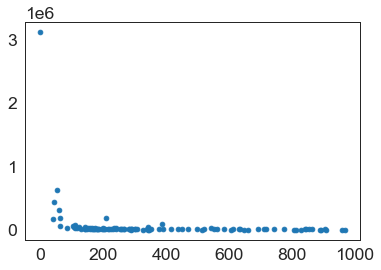

In [255]:
X = df_final['Distance(km)'].values
y = df_final['VISITORS'].values
plt.scatter(X, y, label='data')
plt.show()

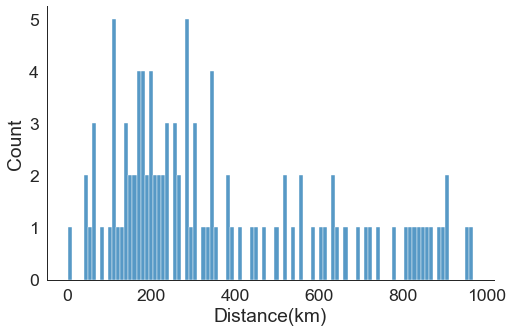

In [256]:
#%pip install seaborn
import seaborn as sns

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_final, x="Distance(km)", kind="hist", bins = 100, aspect = 1.5)


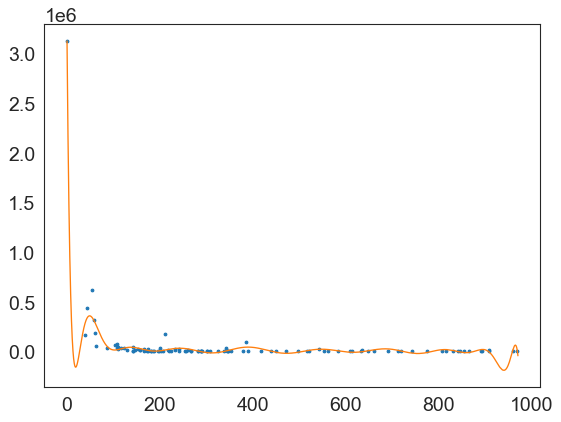

In [257]:
#polynomial regression
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    fittedValues = np.poly1d(np.polyfit(X, y, 20))
xp = np.linspace(0, 970, 100000)
plt.figure(figsize=(8, 6), dpi=80)
_ = plt.plot(X, y, '.', xp, p30(xp), '-')
plt.show()

In [258]:
X = df_final['Distance(km)'].values.reshape(-1, 1)
y = df_final['VISITORS'].values
listt = []
for i in range(len(X)):
    listt.append(np.polyval(fittedValues, X[i]))
est = [np.round(x) for x in listt]
df_final['Estimation'] = est

df_final['Discrapency'] = df_final['VISITORS'] - df_final['Estimation']
df_final['Discrapency'] = df_final['Discrapency'].apply(lambda x: np.sqrt(np.mean(np.square(x))))
df_final
df_final = df_final.sort_values('Discrapency',ascending = False)
df_final.head(5)

,PROVINCIA,VISITORS,prov_name,Distance(km),Estimation,Discrapency
1,Venezia,620236,Padova,53.628082,[343138.0],277098.0
10,Ferrara,53832,Padova,62.449719,[267092.0],213260.0
5,Milano,177380,Padova,209.964526,[13090.0],164290.0
6,Rovigo,163464,Padova,38.794166,[283202.0],119738.0
4,Verona,181604,Padova,60.726589,[284926.0],103322.0


In [226]:
"""
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures


X = df_final['Distance(km)'].values.reshape(-1, 1)
y = df_final['VISITORS'].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=5)
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(X, y, color='red')
    plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='blue')
    plt.title('Polynomail Regression')
    plt.xlabel('Distance(km)')
    plt.ylabel('Visitors')
    plt.show()
    return
viz_polymonial()
listt = []
for i in range(len(X)):
    listt.append(pol_reg.predict(poly_reg.fit_transform(X[i].reshape(-1, 1))))

"""

"\n# Fitting Polynomial Regression to the dataset\nfrom sklearn.preprocessing import PolynomialFeatures\n\n\nX = df_final['Distance(km)'].values.reshape(-1, 1)\ny = df_final['VISITORS'].values\n\n# Splitting the dataset into the Training set and Test set\nfrom sklearn.model_selection import train_test_split \nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)\n\n# Fitting Polynomial Regression to the dataset\nfrom sklearn.preprocessing import PolynomialFeatures\npoly_reg = PolynomialFeatures(degree=5)\nX_poly = poly_reg.fit_transform(X)\npol_reg = LinearRegression()\npol_reg.fit(X_poly, y)\n\n# Visualizing the Polymonial Regression results\ndef viz_polymonial():\n    plt.scatter(X, y, color='red')\n    plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='blue')\n    plt.title('Polynomail Regression')\n    plt.xlabel('Distance(km)')\n    plt.ylabel('Visitors')\n    plt.show()\n    return\nviz_polymonial()\nlistt = []\nfor i in range(len(X)